# ANZ task: Explore the data and tell a visual story

Before running the analysis, the table data has been split up into 4 different tables:
- original data
    - this is where overview will be carried out on the most important big picture view to tell the data story
- authorized transactions
    - these transactions would be reviewed, most importantly trying to understand the security aspect of it to help the cybersecurity team to understand potential security risks that can be garnered from the data.
- posted transactions
    - These transactions have missing fields, making it hard to track
- corporate transactions

In [107]:
# These are necessary libraries that is enabled in Python to perform the analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [53]:
file = 'DATA/original-data.xlsx'

In [54]:
df = pd.read_excel(file)

In [55]:
df.columns


Index(['timestamps', 'date', 'status', 'age', 'gender', 'txn_description',
       'balance', 'amount', 'card_present_flag', 'long', 'lat', 'geometry',
       'merchant_suburb', 'merchant_state', 'merchant_long_lat', 'merch_long',
       'merch_lat'],
      dtype='object')

In [56]:
df.dtypes

timestamps                   object
date                 datetime64[ns]
status                       object
age                           int64
gender                       object
txn_description              object
balance                     float64
amount                      float64
card_present_flag           float64
long                        float64
lat                         float64
geometry                     object
merchant_suburb              object
merchant_state               object
merchant_long_lat            object
merch_long                  float64
merch_lat                   float64
dtype: object

In [91]:
df.isna().sum()

timestamps              0
date                    0
status                  0
age                     0
gender                  0
txn_description         0
balance                 0
amount                  0
card_present_flag    4326
long                    0
lat                     0
geometry                0
merchant_suburb      4326
merchant_state       4326
merchant_long_lat    4326
merch_long              0
merch_lat               0
time                    0
dtype: int64

In [92]:
df.fillna(0, inplace=True)

In [93]:
df.isna().sum()

timestamps           0
date                 0
status               0
age                  0
gender               0
txn_description      0
balance              0
amount               0
card_present_flag    0
long                 0
lat                  0
geometry             0
merchant_suburb      0
merchant_state       0
merchant_long_lat    0
merch_long           0
merch_lat            0
time                 0
dtype: int64

In [57]:
df['timestamps'] = pd.to_datetime(df['timestamps'], format='%Y-%m-%d %H:%M:%S')

Insight: EFTPOS transactions top the list when it comes to most transactions conducted.

<AxesSubplot:>

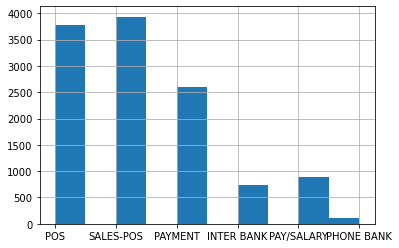

In [23]:
df.txn_description.hist()

Insight: Majority of the transactions are conducted by ages 30 and below

<AxesSubplot:>

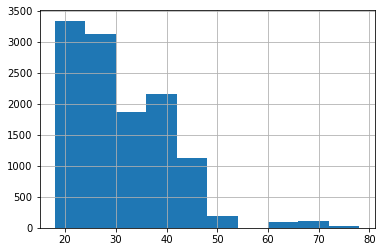

In [16]:
df.age.hist()

In [69]:
time_group = df.groupby('time').sum()

Q: What time of day is the most active for transaction activity? Around 11:06 AM till 16:40 PM

<AxesSubplot:xlabel='time'>

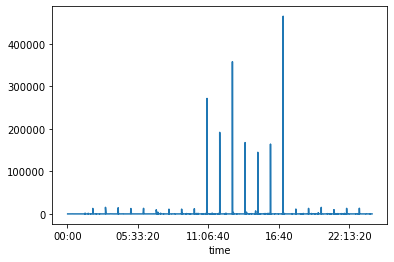

In [70]:
time_group['amount'].plot()

Plot for balance versus time

<AxesSubplot:xlabel='time', ylabel='balance'>

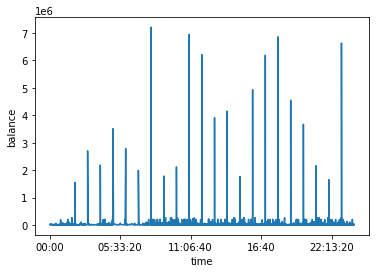

In [73]:
time_group['balance'].plot(ylabel= 'balance')

The plot below shows that overall, people approximating the age of 40 have a higher balance kept in the bank than most other age groups

<AxesSubplot:xlabel='age', ylabel='balance'>

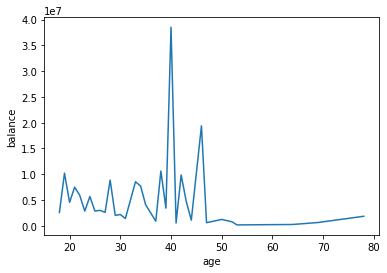

In [32]:
age_group = df.groupby('age').sum()
age_group['balance'].plot(ylabel='balance')


Transactional amounts peak up in ages 20 and 40 years old

<AxesSubplot:xlabel='age', ylabel='amount'>

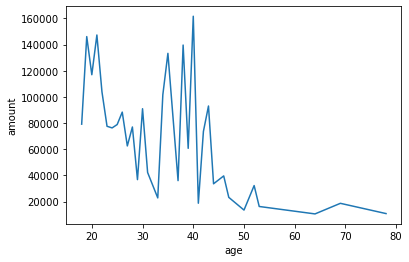

In [73]:
age_group['amount'].plot(ylabel='amount')

In [84]:
# this code sorts the table into authorized vs posted transactions as these columns shows
# high functional dependencies among the columns, which is a violation of 2NF
mask_authorized = df.status == 'authorized'
trans_authorized = df[mask_authorized]
mask_posted = df.status == 'posted'
trans_posted = df[mask_posted]

In [89]:
trans_authorized

,timestamps,date,status,age,gender,txn_description,balance,amount,card_present_flag,long,lat,geometry,merchant_suburb,merchant_state,merchant_long_lat,merch_long,merch_lat,time
0,2018-08-01 01:01:15+00:00,2018-08-01,authorized,26,F,POS,35.39,16.25,1.0,153.41,-27.95,153.41 -27.95,Ashmore,QLD,153.38 -27.99,153.38,-27.99,01:01:15
1,2018-08-01 01:13:45+00:00,2018-08-01,authorized,26,F,SALES-POS,21.20,14.19,0.0,153.41,-27.95,153.41 -27.95,Sydney,NSW,151.21 -33.87,151.21,-33.87,01:13:45
2,2018-08-01 01:26:15+00:00,2018-08-01,authorized,38,M,POS,5.71,6.42,1.0,151.23,-33.94,151.23 -33.94,Sydney,NSW,151.21 -33.87,151.21,-33.87,01:26:15
3,2018-08-01 01:38:45+00:00,2018-08-01,authorized,40,F,SALES-POS,2117.22,40.90,1.0,153.10,-27.66,153.10 -27.66,Buderim,QLD,153.05 -26.68,153.05,-26.68,01:38:45
4,2018-08-01 01:51:15+00:00,2018-08-01,authorized,26,F,SALES-POS,17.95,3.25,1.0,153.41,-27.95,153.41 -27.95,Mermaid Beach,QLD,153.44 -28.06,153.44,-28.06,01:51:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12038,2018-10-31 23:09:06+00:00,2018-10-31,authorized,30,F,POS,14054.14,9.79,0.0,149.83,-29.47,149.83 -29.47,Ringwood,VIC,145.23 -37.81,145.23,-37.81,23:09:06
12039,2018-10-31 23:21:46+00:00,2018-10-31,authorized,20,M,SALES-POS,9137.79,63.87,1.0,151.22,-33.87,151.22 -33.87,Casula,NSW,150.88 -33.96,150.88,-33.96,23:21:46
12040,2018-10-31 23:34:25+00:00,2018-10-31,authorized,28,M,POS,45394.57,43.96,1.0,151.12,-33.89,151.12 -33.89,Kings Park,NSW,150.92 -33.74,150.92,-33.74,23:34:25
12041,2018-10-31 23:47:05+00:00,2018-10-31,authorized,69,M,SALES-POS,11350.67,30.77,1.0,144.96,-37.76,144.96 -37.76,Oakleigh,VIC,145.09 -37.91,145.09,-37.91,23:47:05


In [105]:
df.card_present_flag = df.card_present_flag.astype('int')

KeyError: "None of [Int64Index([1, 0, 1, 1, 1, 0, 1, 1, 1, 0,\n            ...\n            1, 1, 0, 0, 0, 0, 1, 1, 1, 1],\n           dtype='int64', length=12043)] are in the [columns]"